In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
def getData(mode):
    if(mode == "train"):
        df = pd.read_csv("/kaggle/input/processed-data/processed_data/train.csv")
        path = df["Path"].tolist()
        label = df["label"].tolist()
        return path,label
    elif(mode == "valid"):
        df = pd.read_csv("/kaggle/input/processed-data/processed_data/valid.csv")
        path = df["Path"].tolist()
        label = df["label"].tolist()
        return path,label
    else:
        df = pd.read_csv("/kaggle/input/processed-data/processed_data/resnet_18_test.csv")
        path = df["Path"].tolist()
        label = [0] * len(path)
        return path,label


In [3]:
class RetinopathyLoader(Dataset):
    def __init__(self,root,mode,transform=None):
        self.root = root
        self.img_name, self.labels = getData(mode)
        self.transform = transform
        self.mode = mode
        print("> Found %d images..."%(len(self.img_name)))
    def __len__(self):
        return len(self.img_name)
    def __getitem__(self,idx):
        img_name = os.path.join(self.root, os.path.normpath(self.img_name[idx]))
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label



In [4]:
import matplotlib.pyplot as plt
root = "/kaggle/input/processed-data/processed_data"
data_transform = transforms.Compose([
    #transforms.CenterCrop(300),
    #transforms.Resize((80, 80)),  # 保持圖像原始大小
    transforms.RandomHorizontalFlip(),  # 隨機水平翻轉
    transforms.RandomRotation(15),  # 隨機旋轉圖像
    transforms.RandomApply([transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.005, hue=0.005)], p=0.15),
    #transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.7),  # 添加色彩增強，以50%的機率進行處理
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7,sigma=(2))], p=0.15),  # 添加高斯模糊，以20%的機率進行處理
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.23292791,0.08690643,0.2023041],
    std=[0.14168608,0.06099727,0.12721768]
)
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 正規化
])
batch_size = 32
Retinopathy_dataset = RetinopathyLoader(root,"train",transform=data_transform)
train_loader = DataLoader(Retinopathy_dataset, batch_size=batch_size, shuffle=True)
data_transform = transforms.Compose([
    #transforms.CenterCrop(300),
    #transforms.Resize((80, 80)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.23292791,0.08690643,0.2023041],
    std=[0.14168608,0.06099727,0.12721768])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 正規化
])
Retinopathy_dataset = RetinopathyLoader(root,"valid",transform=data_transform)
test_loader =  DataLoader(Retinopathy_dataset, batch_size=batch_size, shuffle=True)



> Found 7995 images...
> Found 1599 images...


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1,drop_prob = 0.0):
        super(BasicBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(drop_prob)
        # 如果输入通道数和输出通道数不一样，使用1x1卷积改变维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv(x)
        out += self.shortcut(x)
        out = self.relu(out)
        out = self.dropout(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000,drop_prob=0.0):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 2, stride=1,drop_prob = drop_prob)
        self.layer2 = self.make_layer(128, 2, stride=2,drop_prob = drop_prob)
        self.layer3 = self.make_layer(256, 2, stride=2,drop_prob = drop_prob)
        self.layer4 = self.make_layer(512, 2, stride=2,drop_prob = drop_prob)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, num_blocks, stride,drop_prob = 0.0):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, drop_prob))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, drop_prob = drop_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# Instantiate the ResNet18 model
model = ResNet18(num_classes=2)
#print(model)




In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
learning_rate = 0.000003
optimizer = optim.Adamax(model.parameters(), lr=learning_rate,weight_decay = 0.0048)
#resnet 50
#learning_rate = 0.002
#optimizer = optim.Adamax(model.parameters(), lr=learning_rate,weight_decay = 0.006)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, dampening=0,weight_decay = 0.001)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 将模型放在 GPU 上（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#resnet18 = nn.DataParallel(resnet18)
print(f"{device} is avaliable")

cuda is avaliable


In [7]:
from torch import save
import copy
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        #preds = (outputs > 0.5).float()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions.double() / len(train_loader.dataset)

    return epoch_loss, epoch_accuracy

# 定义评估函数
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    predict_result=[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            #preds = (outputs > 0.5).float()
            _, preds = torch.max(outputs, 1)
            predict_result.append(preds)
            correct_predictions += torch.sum(preds == labels.data)
        predict_result = torch.cat(predict_result)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = correct_predictions.double() / len(test_loader.dataset)

    return epoch_loss, epoch_accuracy ,predict_result



def test(model, test_loader, device):
    model.eval()
    predict_result=[]
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predict_result.append(preds)
    predict_result = torch.cat(predict_result)

    return predict_result

def save_result(csv_path, predict_result):
    df = pd.read_csv(csv_path)
    new_df = pd.DataFrame()
    new_df['ID'] = df['Path']
    new_df["label"] = predict_result
    new_df.to_csv("/kaggle/working/312581006_resnet18.csv", index=False)



In [ ]:
# 开始训练和评估
num_epochs = 10
best_accuracy = 0.0
train_accuracies = []
eval_accuracies = []
for epoch in range(num_epochs):

    # 训练
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # 评估
    test_loss, test_accuracy,_ = evaluate(model, test_loader, criterion, device)
    eval_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        best_model = copy.deepcopy(model.state_dict())
        best_optimizer = copy.deepcopy(optimizer.state_dict())
    torch.cuda.empty_cache()

#save the best model weights
best_models={
        'best_model_state_dict': best_model,
        'optimizer_state_dict': best_optimizer,
        'loss': test_loss,
        'train_accuracies': train_accuracies,
        'eval_accuracies': eval_accuracies
    }
save(best_models,"/kaggle/working/best_models.pth")
#save the last train model weights
last_models={
        'last_model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': test_loss,
        'train_accuracies': train_accuracies,
        'eval_accuracies': eval_accuracies
    }
save(last_models,"/kaggle/working/last_models.pth")

In [110]:
# Train again (from last epochs)
num_epochs = 2
last_model = torch.load("/content/last_models.pth")
model.load_state_dict(last_model['last_model_state_dict'])
#optimizer.load_state_dict(last_model["optimizer_state_dict"])
#optimizer.param_groups[0]['weight_decay'] = 0.02
best_accuracy = max(last_model['eval_accuracies'])
train_accuracies = last_model['train_accuracies']
eval_accuracies = last_model['eval_accuracies']

# Train again (from best epochs)
# num_epochs = 10
# best_model = torch.load("/content/best_models.pth")
# best_model_state_dict = best_model['best_model_state_dict']
# model.load_state_dict(best_model_state_dict)
# #optimizer.load_state_dict(best_model["optimizer_state_dict"])
# best_accuracy = max(best_model['eval_accuracies'])
# train_accuracies = best_model['train_accuracies']
# eval_accuracies = best_model['eval_accuracies']

for epoch in range(num_epochs):

    # 训练
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # 评估
    test_loss, test_accuracy,_ = evaluate(model, test_loader, criterion, device)
    eval_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

    if (test_accuracy > best_accuracy):
        best_accuracy = test_accuracy
        best_model = copy.deepcopy(model.state_dict())
        best_optimizer = copy.deepcopy(optimizer.state_dict())
    torch.cuda.empty_cache()

#save the best model weights
best_models={
        'best_model_state_dict': best_model,
        'optimizer_state_dict': best_optimizer,
        'loss': test_loss,
        'train_accuracies': train_accuracies,
        'eval_accuracies': eval_accuracies
    }
save(best_models,"/kaggle/working/best_models.pth")
#save the last train model weights
last_models={
        'last_model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': test_loss,
        'train_accuracies': train_accuracies,
        'eval_accuracies': eval_accuracies
    }
save(last_models,"/kaggle/working/last_models.pth")

Epoch 1/2, Training Loss: 0.0854, Training Accuracy: 0.9680

Epoch 1/2, Testing Loss: 0.1102, Testing Accuracy: 0.9637

Epoch 2/2, Training Loss: 0.0913, Training Accuracy: 0.9676

Epoch 2/2, Testing Loss: 0.1109, Testing Accuracy: 0.9619


In [8]:
Retinopathy_dataset = RetinopathyLoader(root,"test",transform=data_transform)
test_loader =  DataLoader(Retinopathy_dataset, batch_size=batch_size, shuffle=False)
best_model = torch.load("/kaggle/input/18best/best_models.pth")
best_model_state_dict = best_model['best_model_state_dict']
model.load_state_dict(best_model_state_dict)
test_loss, test_accuracy ,_= evaluate(model, test_loader, criterion, device)
predict_result = test(model,test_loader, device).cpu().numpy()
save_result("/kaggle/input/processed-data/processed_data/resnet_18_test.csv",predict_result=predict_result)

> Found 1067 images...


In [9]:
best_model = torch.load("/kaggle/input/18best/best_models.pth")
model.load_state_dict(best_model['best_model_state_dict'])
Retinopathy_dataset = RetinopathyLoader(root,"valid",transform=data_transform)
test_loader =  DataLoader(Retinopathy_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy ,predict_result = evaluate(model, test_loader, criterion, device)  
print(f"The best model performence, Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

> Found 1599 images...
The best model performence, Testing Loss: 0.1066, Testing Accuracy: 0.9681


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


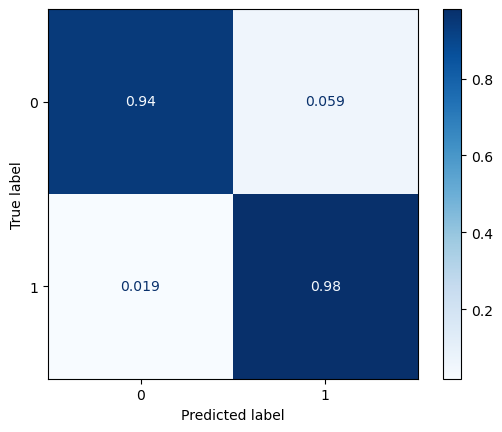

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
file_path = "/kaggle/input/processed-data/processed_data/valid.csv"
df = pd.read_csv(file_path)
true_label = df['label'].values
cm = confusion_matrix(true_label, predict_result.cpu().numpy())
classes = ["0", "1"]
disp = ConfusionMatrixDisplay.from_predictions(true_label, predict_result.cpu().numpy(),normalize="true",cmap = "Blues")


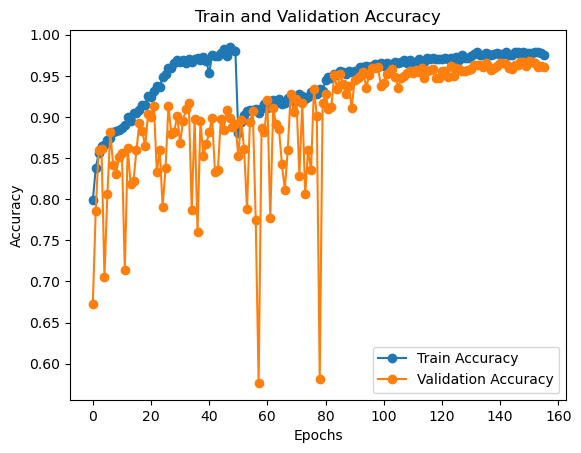

In [11]:
loaded_model = torch.load("/kaggle/input/18best/best_models.pth", map_location=torch.device('cpu'))
train_accuracies = loaded_model['train_accuracies']
eval_accuracies = loaded_model['eval_accuracies']
min_length = min(len(train_accuracies), len(eval_accuracies))
train_accuracies = train_accuracies[:min_length]
eval_accuracies = eval_accuracies[:min_length]
epochs = [x for x in range(0, (min_length ))]
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
# 繪製驗證準確率曲線
plt.plot(epochs, eval_accuracies, label='Validation Accuracy', marker='o')
# 添加標題和標籤
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# 顯示圖形
plt.show()